# **Introduction to Data Science - Mini Project** <br/> _Analyzing organ donation data from Bogotá, Colombia, from 2015 to 2024_

Juan Esteban Alarcón Bravo &nbsp; $\cdot$ &nbsp; `a24juaal`

<br/>
<br/>

---

<br/>
<br/>

This project focuses on analyzing **organ donation data from 2015 to 2024 in Bogotá, Colombia**. We'll start with a presentation of the data, including the import and loading process, followed by cleaning and an initial *Exploratory Data Analysis* (EDA).

After identifying interesting paths to explore, we will proceed to apply techniques such as clustering and various types of regression, aiming to strike a balance that allows us to answer the questions raised during the data exploration phase.

# **1 - Introduction and Motivation**

This section focuses on the significance of this data, its broader impact, and the motivation behind choosing this particular dataset.

## 1.1 - The Motivation

The main motivation was the desire to work with information from my homeland. Additionally, this dataset is collected and compiled by a government agency in Bogotá, making it an interesting opportunity to work with official data while attempting to extract meaningful insights on the topic of public health in the city.

## 1.2 - About the Dataset

The dataset contains about 2100 rows and includes information (in Spanish) on organ donations from 2015 to 2024 from Bogotá, Colombia. The information is provided by the *Secretaría Distrital de Salud* (District Health Office), a government office in charge of health maters for Bogotá. It can be found in this URL: [https://datosabiertos.bogota.gov.co/dataset/numero-de-pacientes-en-espera-para-donacion](https://datosabiertos.bogota.gov.co/dataset/numero-de-pacientes-en-espera-para-donacion)

<br/>

# **2 - Imports and Cleanup**

To begin, we need to import and setup the necessary libraries, load the dataset, and perform some data cleaning.

## 2.1 - Libraries

In [295]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings

# Utilities
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

# Clustering
from sklearn.cluster import KMeans

# Regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# ------------------------------------------------------------------------------

# Set pandas display options
pd.set_option('display.width', 1000)

# Define custom colormap based on Set2
colors = plt.colormaps['Set2'].colors
colors_ext = plt.colormaps['tab20'].colors

# Set default colormap for Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
warnings.filterwarnings('ignore')

## 2.2 - Data

Here, we address the problem of data cleanup, setup, and general preprocessing.

### _Import_

First, we **import** the data from the CSV file into a pandas `DataFrame` and check the first rows, null values and the column names & data types.

In [296]:
# URL RAW del dataset
data_url = "https://raw.githubusercontent.com/jalarconb/DataScience2024II/main/data/raw_trasplantes.csv"

# Cargar el dataset desde GitHub
df = pd.read_csv(data_url, encoding='latin1', delimiter=';', dtype=object)

# Mostrar las primeras filas para verificar
df.head()

,Año,Proceso,Órgano,Sexo,Grupo de edad,Cantidad,Tipo de donante
0,2015,Donación,Riñón,Hombre,No aplica,39,Donante vivo
1,2015,Donación,Riñón,Mujer,No aplica,32,Donante vivo
2,2015,Donación,Riñón,Hombre,No aplica,70,Donante cadaverico
3,2015,Donación,Riñón,Mujer,No aplica,48,Donante cadaverico
4,2015,Donación,Corazón,Hombre,No aplica,0,Donante vivo


In [297]:
# Display the data types and check for missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Año              2120 non-null   object
 1   Proceso          2120 non-null   object
 2   Órgano           2120 non-null   object
 3   Sexo             2120 non-null   object
 4   Grupo de edad    2120 non-null   object
 5   Cantidad         2120 non-null   object
 6   Tipo de donante  2120 non-null   object
dtypes: object(7)
memory usage: 116.1+ KB


,0
Año,0
Proceso,0
Órgano,0
Sexo,0
Grupo de edad,0
Cantidad,0
Tipo de donante,0


As there are no null values in the dataset, we do not need to worry about dealing with them. Also, all the columns but `Cantidad` _(Quantity)_ are categorical; our next step is going to be **text standardization** for those categorical columns.

- **Strip** spaces and put the text in **title case**.
- Check the **unique values** in each column to make sure that there are no duplicates or incorrect values (due to typos, etc.).

In [298]:
# Standardize text in categorical columns (Strip + TitleCase)
df['Año'] = df['Año'].str.strip().str.title()
df['Proceso'] = df['Proceso'].str.strip().str.title()
df['Órgano'] = df['Órgano'].str.strip().str.title()
df['Sexo'] = df['Sexo'].str.strip().str.title()
df['Grupo de edad'] = df['Grupo de edad'].str.strip().str.title()
df['Tipo de donante'] = df['Tipo de donante'].str.strip().str.title()

# Check for unique values in each column
print("Unique values in 'Año':", df['Año'].unique(), "\n")
print("Unique values in 'Proceso':", df['Proceso'].unique(), "\n")
print("Unique values in 'Órgano':", df['Órgano'].unique(), "\n")
print("Unique values in 'Sexo':", df['Sexo'].unique(), "\n")
print("Unique values in 'Grupo de edad':", df['Grupo de edad'].unique(), "\n")
print("Unique values in 'Tipo de donante':", df['Tipo de donante'].unique(), "\n")

Unique values in 'Año': ['2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023'
 '2024 Ii Trim'] 

Unique values in 'Proceso': ['Donación' 'Lista De Espera De Donación De Órganos' 'Trasplantes'
 'Donación Personas'] 

Unique values in 'Órgano': ['Riñón' 'Corazón' 'Hígado' 'Pulmón' 'Combinado Riñón-Hígado'
 'Tejidos (Córneas)' 'No Aplica' 'Combinado Corazón -Riñón' 'Páncreas'
 'Combinado \nRiñón-Páncreas' 'Combinado Riñón-Pancreas'] 

Unique values in 'Sexo': ['Hombre' 'Mujer' 'No Aplica'] 

Unique values in 'Grupo de edad': ['No Aplica' '0-9 Años' '10-19 Años' '20-29 Años' '30-39 Años'
 '40-49 Años' '50-59 Años' '60-69 Años' '> 70  Años'] 

Unique values in 'Tipo de donante': ['Donante Vivo' 'Donante Cadaverico' 'No Aplica' 'Donante Cadavérico'] 



### _Cleanup & Preprocessing_

Some values require attention. In `Año` (_"Year"_), for instance, the year _2024_ includes not only the year itself but also an indication of the trimester (_"2024 Ii Trim"_). This shows a clear bias in the data, as the year 2024 contains fewer observations compared to other years, which represent complete annual data.

<div class="alert alert-block alert-info">
<b>Note:</b> This particular year-bias is going to be important for some of the next steps of the project but, for the time being, we are going to change all the occurrences to "2024".
</div>

As for the other columns, there are some missing and extra characters and accents; we can work on that.

Also, the `Tipo de Donante` (Donor Type) column can be changed; we can rename it as `Donante_Vivo` to check whether the donor is alive or not (`1` or `0`, respectively). As for the "No Aplica" (Does not apply) values, we will assign `-1`:

In [299]:
# Rename columns

df.rename(columns={'Tipo de donante': 'Donante_Vivo', 'Grupo de edad':'Grupo_Edad'}, inplace=True)

# Cleanup: 'Año' (Year)
df['Año'] = df['Año'].replace({
    '2024 Ii Trim': '2024'
})

# Cleanup: 'Proceso' (Process)
df['Proceso'] = df['Proceso'].replace({
    'Lista De Espera De Donación De Órganos': 'Lista de Espera',
    'Trasplantes': 'Trasplante',
})

# Cleanup: 'Órgano' (Organ)
df['Órgano'] = df['Órgano'].replace({
    'No Aplica': 'NA',
    'Combinado Corazón -Riñón': 'Combinado Corazón-Riñón',
    'Combinado \nRiñón-Páncreas': 'Combinado Riñón-Páncreas',
    'Combinado Riñón-Pancreas': 'Combinado Riñón-Páncreas',
    'Tejidos (Córneas)': 'Córneas'
})

# Cleanup: 'Sexo' (Sex)
df['Sexo'] = df['Sexo'].replace({
    'Hombre': '1',
    'Mujer': '0',
    'No Aplica': '-1'
})

# Cleanup: 'Grupo_Edad' (Age Group)
df['Grupo_Edad'] = df['Grupo_Edad'].replace({
    'No Aplica': 'NA',
    '> 70  Años': '> 70 Años'
})

# Cleanup: 'Donante_Vivo' (Is Donor Alive?)
df['Donante_Vivo'] = df['Donante_Vivo'].replace({
    'No Aplica': '-1',
    'Donante Vivo': '1',
    'Donante Cadaverico': '0',
    'Donante Cadavérico': '0',
})

print(df.head())

    Año   Proceso   Órgano Sexo Grupo_Edad Cantidad Donante_Vivo
0  2015  Donación    Riñón    1         NA       39            1
1  2015  Donación    Riñón    0         NA       32            1
2  2015  Donación    Riñón    1         NA       70            0
3  2015  Donación    Riñón    0         NA       48            0
4  2015  Donación  Corazón    1         NA        0            1


In [300]:
# Check unique values in each modified column
print("Unique values in 'Año':", df['Año'].unique(), "\n")
print("Unique values in 'Proceso':", df['Proceso'].unique(), "\n")
print("Unique values in 'Órgano':", df['Órgano'].unique(), "\n")
print("Unique values in 'Grupo_Edad':", df['Grupo_Edad'].unique(), "\n")
print("Unique values in 'Donante_Vivo':", df['Donante_Vivo'].unique(), "\n")

Unique values in 'Año': ['2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024'] 

Unique values in 'Proceso': ['Donación' 'Lista de Espera' 'Trasplante' 'Donación Personas'] 

Unique values in 'Órgano': ['Riñón' 'Corazón' 'Hígado' 'Pulmón' 'Combinado Riñón-Hígado' 'Córneas'
 'NA' 'Combinado Corazón-Riñón' 'Páncreas' 'Combinado Riñón-Páncreas'] 

Unique values in 'Grupo_Edad': ['NA' '0-9 Años' '10-19 Años' '20-29 Años' '30-39 Años' '40-49 Años'
 '50-59 Años' '60-69 Años' '> 70 Años'] 

Unique values in 'Donante_Vivo': ['1' '0' '-1'] 



We should also change the data type of `Año`, `Cantidad` and `Donante_Vivo` to numeric.

In [301]:
#  Change 'Año' to numeric
df['Año'] = pd.to_numeric(df['Año'], errors='coerce')

#  Change 'Cantidad' to numeric
df['Cantidad'] = pd.to_numeric(df['Cantidad'], errors='coerce')

#  Change 'Sexo' to numeric
df['Sexo'] = pd.to_numeric(df['Sexo'], errors='coerce')

#  Change 'Donante_Vivo' to numeric
df['Donante_Vivo'] = pd.to_numeric(df['Donante_Vivo'], errors='coerce')

# Check for null values
df.isnull().sum()

,0
Año,0
Proceso,0
Órgano,0
Sexo,0
Grupo_Edad,0
Cantidad,0
Donante_Vivo,0


And the `Grupo_Edad` column can be Ordinal Encoded to ease manipulation

In [302]:
# Encode Grupo_Edad
encoder = OrdinalEncoder()
df['Grupo_Edad_Encoded'] = encoder.fit_transform(df[['Grupo_Edad']])

df.head()

,Año,Proceso,Órgano,Sexo,Grupo_Edad,Cantidad,Donante_Vivo,Grupo_Edad_Encoded
0,2015,Donación,Riñón,1,NA,39,1,8.0
1,2015,Donación,Riñón,0,NA,32,1,8.0
2,2015,Donación,Riñón,1,NA,70,0,8.0
3,2015,Donación,Riñón,0,NA,48,0,8.0
4,2015,Donación,Corazón,1,NA,0,1,8.0


The `Órgano` column presents a unique case: some rows refer to multi-organ transplants (two organs). This requires an additional consideration for two key reasons. First, these rows contain valuable data about the transplants of both organs involved. Second, we can conduct a separate analysis focusing on these combined rows later.

The approach that we will follow in order to address this problem is:

- **Add a new column** (`Combinado`) to mark the multi-organ rows.
- **Split** each multi-organ row into two separate rows, assigning one organ to each row while retaining all other relevant information.

In [303]:
# Unique Values: Organs
df['Órgano'].unique()

array(['Riñón', 'Corazón', 'Hígado', 'Pulmón', 'Combinado Riñón-Hígado',
       'Córneas', 'NA', 'Combinado Corazón-Riñón', 'Páncreas',
       'Combinado Riñón-Páncreas'], dtype=object)

In [304]:
# Step 1 - Add "Combinado" Column: 1 if combined, 0 else
df.loc[:, 'Combinado'] = df['Órgano'].apply(lambda x: 1 if 'Combinado' in x else 0)
df.head()

,Año,Proceso,Órgano,Sexo,Grupo_Edad,Cantidad,Donante_Vivo,Grupo_Edad_Encoded,Combinado
0,2015,Donación,Riñón,1,NA,39,1,8.0,0
1,2015,Donación,Riñón,0,NA,32,1,8.0,0
2,2015,Donación,Riñón,1,NA,70,0,8.0,0
3,2015,Donación,Riñón,0,NA,48,0,8.0,0
4,2015,Donación,Corazón,1,NA,0,1,8.0,0


In [305]:
# Step 2 - Split the combined rows
def split_combined(row):
    if row['Combinado'] == 1:
        # Split organs using "-", remove "Combinado" keyword
        organs = [org.replace('Combinado ', '') for org in row['Órgano'].split('-')]
        return pd.DataFrame({
            'Órgano': organs,
            'Combinado': [1] * len(organs),
            'Sexo': [row['Sexo']] * len(organs),
            'Grupo_Edad': [row['Grupo_Edad']] * len(organs),
            'Cantidad': [row['Cantidad']] * len(organs),
            'Donante_Vivo': [row['Donante_Vivo']] * len(organs),
            'Año': [row['Año']] * len(organs),
            'Proceso': [row['Proceso']] * len(organs)
        })
    else:
        # Keep the rest without changes
        return pd.DataFrame([row])

# Apply to each row and concat result
df = pd.concat(df.apply(split_combined, axis=1).tolist(), ignore_index=True)

# Print results
print(df.head())

print("\nUnique values for [Órgano]:\n",df['Órgano'].unique())

    Año   Proceso   Órgano  Sexo Grupo_Edad  Cantidad  Donante_Vivo  Grupo_Edad_Encoded  Combinado
0  2015  Donación    Riñón     1         NA        39             1                 8.0          0
1  2015  Donación    Riñón     0         NA        32             1                 8.0          0
2  2015  Donación    Riñón     1         NA        70             0                 8.0          0
3  2015  Donación    Riñón     0         NA        48             0                 8.0          0
4  2015  Donación  Corazón     1         NA         0             1                 8.0          0

Unique values for [Órgano]:
 ['Riñón' 'Corazón' 'Hígado' 'Pulmón' 'Córneas' 'NA' 'Páncreas']


Afterwards, we can also Label Encode it

In [306]:
# Encode Órgano
encoder = LabelEncoder()
df['Órgano_Encoded'] = encoder.fit_transform(df[['Órgano']])

df.head()

,Año,Proceso,Órgano,Sexo,Grupo_Edad,Cantidad,Donante_Vivo,Grupo_Edad_Encoded,Combinado,Órgano_Encoded
0,2015,Donación,Riñón,1,NA,39,1,8.0,0,6
1,2015,Donación,Riñón,0,NA,32,1,8.0,0,6
2,2015,Donación,Riñón,1,NA,70,0,8.0,0,6
3,2015,Donación,Riñón,0,NA,48,0,8.0,0,6
4,2015,Donación,Corazón,1,NA,0,1,8.0,0,0


### _DataFrame Separation_

We will work with two subsets of the main dataframe (`df`):

- One with only the transplant rows (`df_trasplantes`)
- The other with only the donation rows (`df_donaciones`).

In [307]:
# Filtered DF: Process is a Transplant
df_trasplantes = df[df['Proceso'] == 'Trasplante']
df_trasplantes.head()

,Año,Proceso,Órgano,Sexo,Grupo_Edad,Cantidad,Donante_Vivo,Grupo_Edad_Encoded,Combinado,Órgano_Encoded
944,2015,Trasplante,Riñón,1,0-9 Años,4,-1,0.0,0,6
945,2015,Trasplante,Riñón,1,10-19 Años,12,-1,1.0,0,6
946,2015,Trasplante,Riñón,1,20-29 Años,16,-1,2.0,0,6
947,2015,Trasplante,Riñón,1,30-39 Años,30,-1,3.0,0,6
948,2015,Trasplante,Riñón,1,40-49 Años,26,-1,4.0,0,6


In [308]:
# Filtered DF: Process is a Donation
df_donaciones = df[df['Proceso'] == 'Donación']
df_donaciones.head()

,Año,Proceso,Órgano,Sexo,Grupo_Edad,Cantidad,Donante_Vivo,Grupo_Edad_Encoded,Combinado,Órgano_Encoded
0,2015,Donación,Riñón,1,NA,39,1,8.0,0,6
1,2015,Donación,Riñón,0,NA,32,1,8.0,0,6
2,2015,Donación,Riñón,1,NA,70,0,8.0,0,6
3,2015,Donación,Riñón,0,NA,48,0,8.0,0,6
4,2015,Donación,Corazón,1,NA,0,1,8.0,0,0


# **3 - EDA: Transplants**

We will start with a statistical exploration of the transplants dataset (`df_trasplantes`). This includes performing correlation tests to uncover potential hidden relationships and identify opportunities for data mining.

In this sub-dataset, the `Donante_Vivo` column doesn't provide any data, so we can remove it:

In [309]:
print("\nUnique values for [Donante_Vivo]:\n",df_trasplantes['Donante_Vivo'].unique())


Unique values for [Donante_Vivo]:
 [-1]


In [310]:
df_trasplantes.drop(columns=['Donante_Vivo'], inplace=True)
df_trasplantes.head()

,Año,Proceso,Órgano,Sexo,Grupo_Edad,Cantidad,Grupo_Edad_Encoded,Combinado,Órgano_Encoded
944,2015,Trasplante,Riñón,1,0-9 Años,4,0.0,0,6
945,2015,Trasplante,Riñón,1,10-19 Años,12,1.0,0,6
946,2015,Trasplante,Riñón,1,20-29 Años,16,2.0,0,6
947,2015,Trasplante,Riñón,1,30-39 Años,30,3.0,0,6
948,2015,Trasplante,Riñón,1,40-49 Años,26,4.0,0,6


## 3.1 - General Analysis an Descriptive Statistics

We use these two tools to gain a general understanding of the data and to address the fundamental questions about the state of the art on the topic:
- How many donations are there per year, historically?
- Which age group contributes the most to donations?

### _Transplants Evolution by Year_

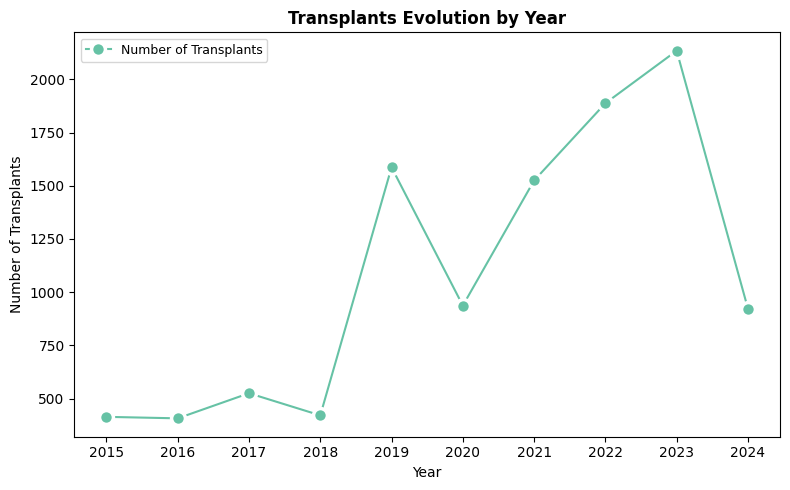

In [311]:
# Group by year and sum the quantities
df_yearly = df_trasplantes.groupby("Año")["Cantidad"].sum().reset_index()

# Configure the plot
plt.figure(figsize=(8, 5))
plt.plot(
    df_yearly["Año"],
    df_yearly["Cantidad"],
    marker="o",
    linewidth=1.5,
    markersize=10,
    markeredgecolor="white",
    markeredgewidth=2.5,
    label="Number of Transplants"
)

# Axis labels and title
plt.xlabel("Year", fontsize=10)
plt.ylabel("Number of Transplants", fontsize=10)
plt.title("Transplants Evolution by Year", fontsize=12, weight="bold")

# Add legend
plt.xticks(df_yearly["Año"])
plt.legend(fontsize=9)

# Display the plot
plt.tight_layout()
plt.show()

### _Transplant by Age Group_

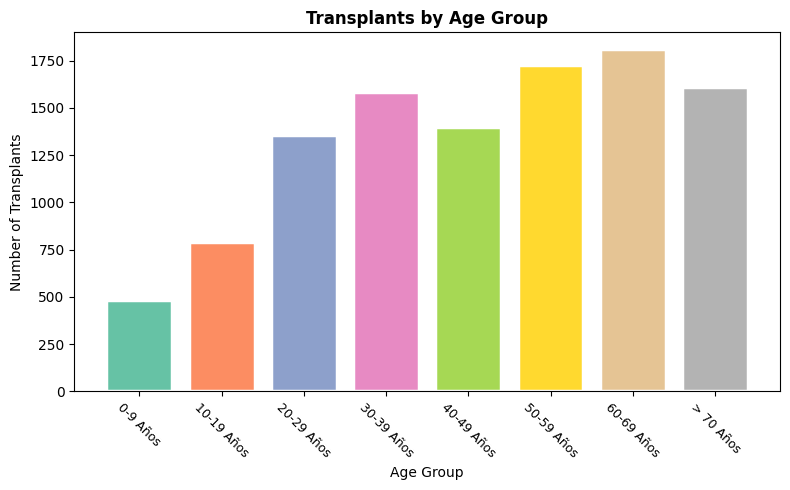

In [312]:
# Group by age group and sum the quantities
df_age_group = df_trasplantes.groupby("Grupo_Edad")["Cantidad"].sum().reset_index()

# Configure the plot
plt.figure(figsize=(8, 5))
plt.bar(
    df_age_group["Grupo_Edad"],
    df_age_group["Cantidad"],
    color=colors[:len(df_age_group)],
    edgecolor="white",
    linewidth=2.5,
)

# Axis labels and title
plt.xlabel("Age Group", fontsize=10)
plt.ylabel("Number of Transplants", fontsize=10)
plt.title("Transplants by Age Group", fontsize=12, weight="bold")

# Rotate x-axis labels for better readability
plt.xticks(rotation=-45, ha="center", va="top", fontsize=9)

# Display the plot
plt.tight_layout()
plt.show()

## 3.2 - Correlation Analysis

Since we are working with **categorical variables** (sex, organ, age group, etc.), directly applying a standard correlation measure (Spearman, etc.) would not be appropriate in this case. After some research, I found a more advanced methods that we could consider, *Cramér's V.*

**Cramér's V** is a measure of association between two categorical variables based on the Chi-squared statistic. It handles categorical variables without requiring numerical transformations.

### _Sex vs. Organ_

**Step 1: Build a contingency table**

We'll start by creating a contingency table where each cell represents the sum of `Cantidad` for a combination of `Órgano` and `Sexo`.

In [313]:
# Contingency table
contingency_table = df_trasplantes.pivot_table(
    values='Cantidad',
    index='Órgano',
    columns='Sexo',
    aggfunc='sum',
    fill_value=0
)

print("Contingency Table (Sum of 'Cantidad'):")
print(contingency_table)

Contingency Table (Sum of 'Cantidad'):
Sexo         0     1
Órgano              
Corazón     55   139
Córneas   2930  3582
Hígado     586   552
Pulmón      53    64
Páncreas     0     1
Riñón     1127  1673


**Step 2: Compute Chi-squared statistic and Cramér's V**

We use the contingency table to calculate the Chi-squared statistic and then Cramér's V:

In [314]:
from scipy.stats import chi2_contingency

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("\nExpected frequencies:\n", expected)
print("\nCramér's V:", cramers_v)

Chi-squared statistic: 64.53682113431675
p-value: 1.3981859957982608e-12
Degrees of Freedom: 5

Expected frequencies:
 [[8.56433748e+01 1.08356625e+02]
 [2.87479205e+03 3.63720795e+03]
 [5.02382271e+02 6.35617729e+02]
 [5.16509013e+01 6.53490987e+01]
 [4.41460695e-01 5.58539305e-01]
 [1.23608995e+03 1.56391005e+03]]

Cramér's V: 0.0774385640122251


**About the results:**

- **Chi-squared statistic:** Indicates how far the observed data is from what would be expected if there were no relationship between Órgano and Sexo.

- **p-value:** Tests the null hypothesis that Órgano and Sexo are independent: Since we have a small p-value (< 0.05), we are rejecting the null hypothesis, meaning there’s likely an association.

- **Cramér's V:** A value of  less than 0.1 means that there is little to no association, like in this case. `0.077` indicates a very weak association, even though it’s statistically significant.

And, since this relationship is not really meaningfull, we **will not keep on exploring** this path and, instead, focus on the other relations.

### _Sex vs. Age Group_

In [315]:
# Contingency table
contingency_table = df_trasplantes.pivot_table(
    values='Cantidad',
    index='Sexo',
    columns='Grupo_Edad',
    aggfunc='sum',
    fill_value=0
)

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("TRANSPLANT CORRELATION\nSex vs. Age Group\n")
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Cramér's V:", cramers_v)

print("\nNOT A MEANINGFUL CORRELATION")

TRANSPLANT CORRELATION
Sex vs. Age Group

Chi-squared statistic: 140.25616878180708
p-value: 4.492087099018914e-27
Cramér's V: 0.11416013980026661

NOT A MEANINGFUL CORRELATION


### _Year vs. Age Group_

In [316]:
# Contingency table
contingency_table = df_trasplantes.pivot_table(
    values='Cantidad',
    index='Grupo_Edad',
    columns='Año',
    aggfunc='sum',
    fill_value=0
)

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("TRANSPLANT CORRELATION\nYear vs. Age Group\n")
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Cramér's V:", cramers_v)

print("\nNOT A MEANINGFUL CORRELATION")

TRANSPLANT CORRELATION
Year vs. Age Group

Chi-squared statistic: 409.11703518789164
p-value: 3.4946336422663936e-52
Cramér's V: 0.07369334464449262

NOT A MEANINGFUL CORRELATION


### _Organ vs. Age Group_

In [317]:
# Contingency table
contingency_table = df_trasplantes.pivot_table(
    values='Cantidad',
    index='Grupo_Edad',
    columns='Órgano',
    aggfunc='sum',
    fill_value=0
)

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("TRANSPLANT CORRELATION\nYear vs. Age Group\n")
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Cramér's V:", cramers_v)

print("\nSLIGHT CORRELATION, BUT NOT REALLY MEANINGFUL")

TRANSPLANT CORRELATION
Year vs. Age Group

Chi-squared statistic: 2447.7504003017652
p-value: 0.0
Cramér's V: 0.21328095127281424

SLIGHT CORRELATION, BUT NOT REALLY MEANINGFUL


# **4 - EDA: Donations**

Now, we will explore the donations dataset (`df_donaciones`).

In this sub-dataset, the `Grupo_Edad` column doesn't provide any data, so we can remove it:

In [318]:
print("\nUnique values for [Grupo_Edad]:\n",df_donaciones['Grupo_Edad'].unique())


Unique values for [Grupo_Edad]:
 ['NA']


In [319]:
df_donaciones.drop(columns=['Grupo_Edad', 'Grupo_Edad_Encoded'], inplace=True)
df_donaciones.head()

,Año,Proceso,Órgano,Sexo,Cantidad,Donante_Vivo,Combinado,Órgano_Encoded
0,2015,Donación,Riñón,1,39,1,0,6
1,2015,Donación,Riñón,0,32,1,0,6
2,2015,Donación,Riñón,1,70,0,0,6
3,2015,Donación,Riñón,0,48,0,0,6
4,2015,Donación,Corazón,1,0,1,0,0


## 4.1 - Correlation Analysis

Once again, we will apply **Cramér's V**.

### _Sex vs. Organ_

In [320]:
# Contingency table
contingency_table = df_donaciones.pivot_table(
    values='Cantidad',
    index='Órgano',
    columns='Sexo',
    aggfunc='sum',
    fill_value=0
)

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("TRANSPLANT CORRELATION\nOrgan vs. Sex\n")
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Cramér's V:", cramers_v)

print("\nNOT A MEANINGFUL CORRELATION")

TRANSPLANT CORRELATION
Organ vs. Sex

Chi-squared statistic: 11.249296011634785
p-value: 0.04665518541805849
Cramér's V: 0.05490982352257469

NOT A MEANINGFUL CORRELATION


### _Sex vs. Donor Alive_

In [321]:
# Contingency table
contingency_table = df_donaciones.pivot_table(
    values='Cantidad',
    index='Sexo',
    columns='Donante_Vivo',
    aggfunc='sum',
    fill_value=0
)

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("TRANSPLANT CORRELATION\nSex vs. Donor Alive\n")
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Cramér's V:", cramers_v)

print("\nNOT A MEANINGFUL CORRELATION")

TRANSPLANT CORRELATION
Sex vs. Donor Alive

Chi-squared statistic: 26.376088777781575
p-value: 2.8099764654799694e-07
Cramér's V: 0.08407997491154554

NOT A MEANINGFUL CORRELATION


### _Year vs. Donor Alive_

In [322]:
# Contingency table
contingency_table = df_donaciones.pivot_table(
    values='Cantidad',
    index='Donante_Vivo',
    columns='Año',
    aggfunc='sum',
    fill_value=0
)

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("TRANSPLANT CORRELATION\nYear vs. Donor Alive\n")
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Cramér's V:", cramers_v)

print("\nSLIGHT CORRELATION, BUT NOT REALLY MEANINGFUL")

TRANSPLANT CORRELATION
Year vs. Donor Alive

Chi-squared statistic: 57.59578548789974
p-value: 3.885497999892006e-09
Cramér's V: 0.12424608936744712

SLIGHT CORRELATION, BUT NOT REALLY MEANINGFUL


### _Organ vs. Donor Alive_

In [323]:
# Contingency table
contingency_table = df_donaciones.pivot_table(
    values='Cantidad',
    index='Donante_Vivo',
    columns='Órgano',
    aggfunc='sum',
    fill_value=0
)

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("TRANSPLANT CORRELATION\nOrgan vs. Donor Alive\n")
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Cramér's V:", cramers_v)

print("\nSLIGHT CORRELATION")

TRANSPLANT CORRELATION
Organ vs. Donor Alive

Chi-squared statistic: 273.30331327406327
p-value: 5.463665691881641e-57
Cramér's V: 0.27065111701957967

SLIGHT CORRELATION


**We can further explore this last correlation in the next section.**

# **5 - Clustering: Donations**

As we observed in the previous exploration, there **seems to be some correlation between `Donor Alive` and `Organ` for Donations**. We will now attempt to analyze this relationship through **clustering**.

## 5.1 - Normalization of Cantidad

In order to properly work with the `Cantidad` variable, we have to **normalize** it according to its behaviour.

The `Cantidad` column represent a wide range of numerical values, so we start by doing some **descriptive statistics** to get a better understanding of the data.

In [324]:
# Statistical description of the Cantidad column
print("Descriptive statistics for Cantidad:")
print(df_donaciones['Cantidad'].describe())

# Print the Median
print(f"\nMedian: {df_donaciones['Cantidad'].median()}")

# Calculate the IQR and the limits
q1 = df_donaciones['Cantidad'].quantile(0.25)
q3 = df_donaciones['Cantidad'].quantile(0.75)
iqr = q3 - q1

lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

print(f"IQR:{iqr}\nLower limit: {lower_limit}\nUpper limit: {upper_limit}")

Descriptive statistics for Cantidad:
count    236.000000
mean      15.809322
std       24.124890
min        0.000000
25%        0.000000
50%        5.000000
75%       24.000000
max      148.000000
Name: Cantidad, dtype: float64

Median: 5.0
IQR:24.0
Lower limit: -36.0
Upper limit: 60.0


Some observations:
- The `mean` (_~15_) is significantly lower than the `max` (_148_). This hints that the distribution is **right skewed**.
- Also, the `median` (_5_) is smaller than the `mean` (_15_), further supporting this hypothesis.

With that in mind, we now check the IQR and limits, and their relationship with the actual data:
- First, while the `lower limit` is _-36_, the `min` is _0_. Thus, there are **no negative outliers** in the data.
- On the other hand, the `upper limit` is _60_, so every value above that should be considered an outlier.

Visualizing the data, we can notice the big tail of the distribution (skewness) in the histogram, and the outliers in the boxplot:

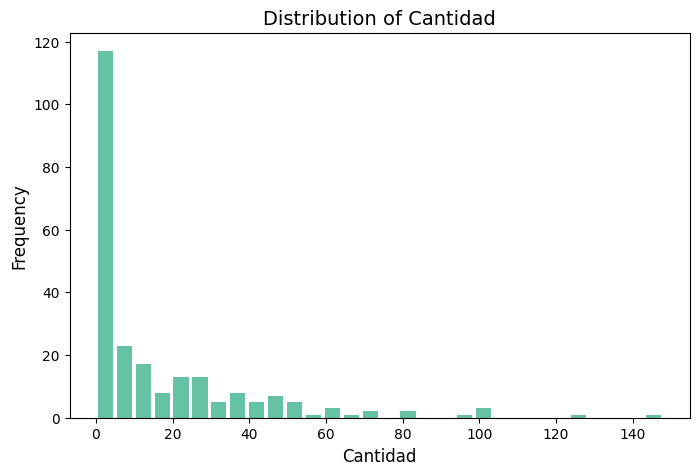

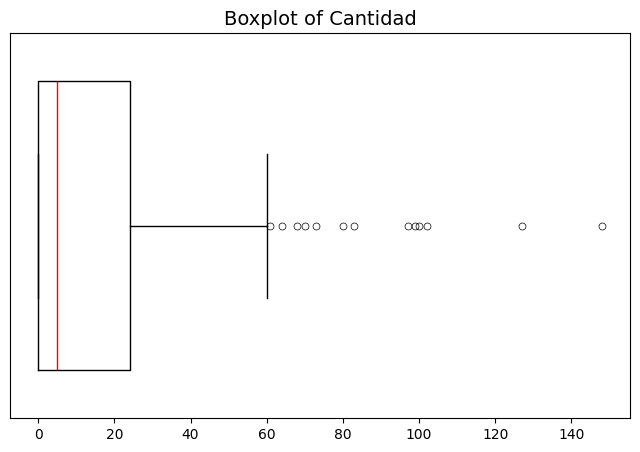

In [325]:
# Histogram: Cantidad
plt.figure(figsize=(8, 5))
plt.hist(df_donaciones['Cantidad'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df_donaciones['Cantidad'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

To address this skewness, we will aply a <span style="color:teal">**log transformation**</span> to the data and then generate the statistical summary and plots again.

<div class="alert alert-block alert-success">
  <span>✅</span> One of the most important advantages of this technique compared to other alternatives (such as <em>min-max</em> or <em>z-score</em>) is the <strong>reduction of the asymmetry</strong> of the distribution, a very valuable point when dealing with extreme outliers that we are not removing.
</div>

Descriptive statistics for Cantidad_log:
count    236.000000
mean       1.724966
std        1.589811
min        0.000000
25%        0.000000
50%        1.791759
75%        3.218876
max        5.003946
Name: Cantidad_log, dtype: float64

Median: 1.791759469228055
IQR: 3.2188758248682006
Lower limit: -4.828313737302301
Upper limit: 8.047189562170502



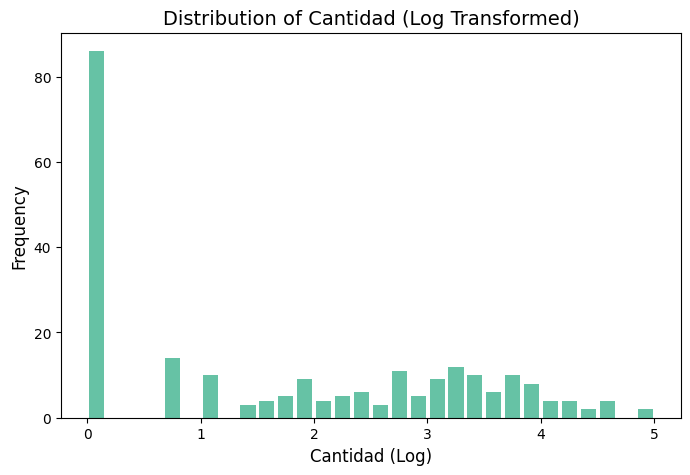

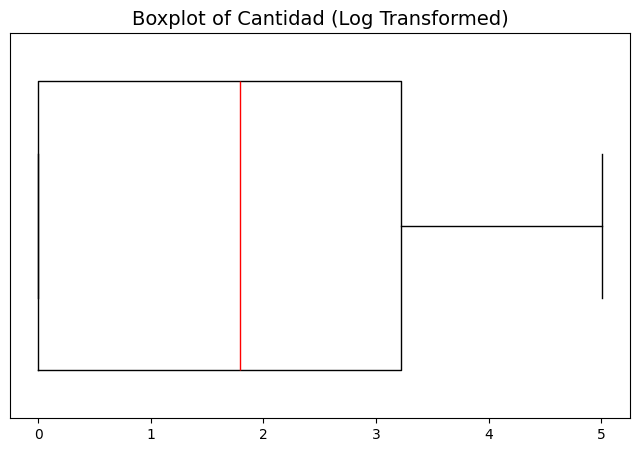

In [326]:
# Apply log transformation to 'Cantidad'
df_donaciones.loc[:, 'Cantidad_log'] = np.log1p(df_donaciones['Cantidad'])  # .loc to get rid of a Warning

# Descriptive statistics
print("Descriptive statistics for Cantidad_log:")
print(df_donaciones['Cantidad_log'].describe())

# The median
print(f"\nMedian: {df_donaciones['Cantidad_log'].median()}")

# Calculate the IQR and the limits for the log-transformed column
q1_log = df_donaciones['Cantidad_log'].quantile(0.25)
q3_log = df_donaciones['Cantidad_log'].quantile(0.75)
iqr_log = q3_log - q1_log

lower_limit_log = q1_log - 1.5 * iqr_log
upper_limit_log = q3_log + 1.5 * iqr_log

print(f"IQR: {iqr_log}\nLower limit: {lower_limit_log}\nUpper limit: {upper_limit_log}\n")


# Then, we plot again...

# Histogram: Cantidad (log-transformed)
plt.figure(figsize=(8, 5))
plt.hist(df_donaciones['Cantidad_log'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad (Log Transformed)', fontsize=14)
plt.xlabel('Cantidad (Log)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad (log-transformed)
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df_donaciones['Cantidad_log'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad (Log Transformed)', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

## 5.2 - Subset Definition

Now, we select the relevant metrics that we want to keep for the clustering algorithm execution.

In [327]:
# Define a subset for the clustering technique

print(df_donaciones.head())
print()

df_num = df_donaciones[['Órgano_Encoded','Donante_Vivo', 'Cantidad_log']]
print(df_num.head())

    Año   Proceso   Órgano  Sexo  Cantidad  Donante_Vivo  Combinado  Órgano_Encoded  Cantidad_log
0  2015  Donación    Riñón     1        39             1          0               6      3.688879
1  2015  Donación    Riñón     0        32             1          0               6      3.496508
2  2015  Donación    Riñón     1        70             0          0               6      4.262680
3  2015  Donación    Riñón     0        48             0          0               6      3.891820
4  2015  Donación  Corazón     1         0             1          0               0      0.000000

   Órgano_Encoded  Donante_Vivo  Cantidad_log
0               6             1      3.688879
1               6             1      3.496508
2               6             0      4.262680
3               6             0      3.891820
4               0             1      0.000000


## 5.3 - Cluster: Órgano_Encoded vs. Donante_Vivo (sum. w/ Cantidad)

We will apply **K-Means** to the number of donations by organ and donor status (living/deceased). This algorithm is simple to implement and understand, easily scalable, and its computation for small datasets like this one is fast.

For hyperparameter tuning, we will use an **elbow plot** *(specifically to decide on $K$)*.

For the evaluation of the model, we will use two metrics: **Silhouette Score** and the **Calinski-Harabasz Index**. The first is an indicator of *intra-cluster cohesion and inter-cluster separation*; a value of 1 is good, values close to 0 are bad, and negative values indicate poor clustering. Calinski-Harabasz, on the other hand, measures the *distance between internal and external variability*, with higher values generally being better.

### _Elbow Plot_

Text(0.5, 1.0, 'Elbow Plot: Optimal K')

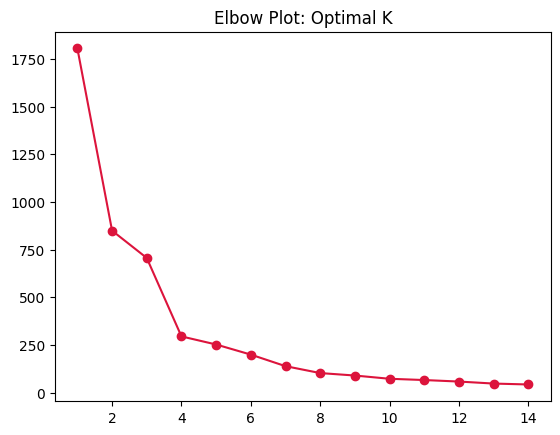

In [328]:
wscc = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, init="k-means++",random_state=12)
    kmeans.fit(df_num)
    wscc.append(kmeans.inertia_)

# Elbowplot: Optimal K
plt.plot(range(1,15),wscc,marker="o",c="crimson")
plt.title("Elbow Plot: Optimal K")

###_K-Means_

In [329]:
k_means = KMeans(n_clusters=4, random_state=12)
k_means.fit(df_num)
centers = k_means.cluster_centers_

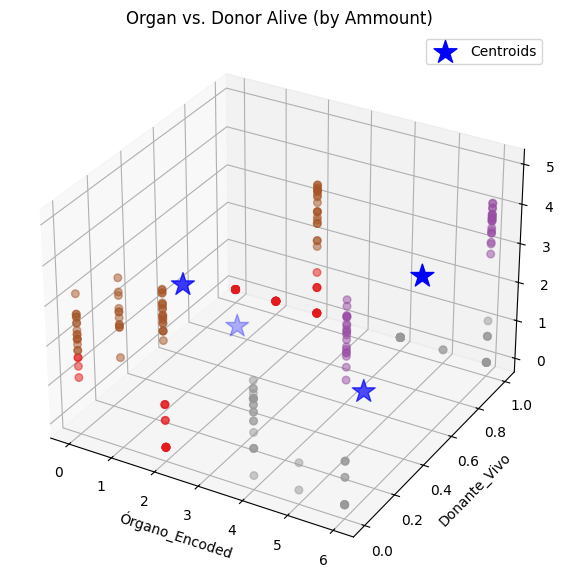

In [330]:
variables = ['Órgano_Encoded', 'Donante_Vivo', 'Cantidad_log']

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot: Donante_Vivo vs. Cantidad_log vs. Año
scatter = ax.scatter(
    df_num[variables[0]],  # Eje X
    df_num[variables[1]],  # Eje Y
    df_num[variables[2]],  # Eje Z
    c=k_means.labels_,  # Colores según cluster
    cmap='Set1',
    s=30,
    alpha=0.5
)

# Centroides
ax.scatter(
    centers[:, 0],  # Centroide eje X
    centers[:, 1],  # Centroide eje Y
    centers[:, 2],  # Centroide eje Z
    color='blue',
    marker='*',
    s=300,
    label='Centroids'
)

# Etiquetas y título
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
ax.set_title('Organ vs. Donor Alive (by Ammount)')
ax.legend()

plt.show()

### _Scoring and Evaluation_

The **Silhouette Score** is not bad, but it doesn't stand out either. The **Calinski-Harabasz Index** is very high. However, we can appreciate that the clustering generated **doesn't actually provide any relevant information**. The grouping, although seemingly adequate and uniform in some ways, does not produce any valuable insights.

In [331]:
# Silhouette Score
silhouette_score = metrics.silhouette_score (df_num, k_means.labels_)
print("Silhouette Score = ", silhouette_score)

# Calinski-Harabasz Index
calinski_score = metrics.calinski_harabasz_score(df_num, k_means.labels_)
print(f"Calinski-Harabasz Index = {calinski_score}")

Silhouette Score =  0.5569754250815739
Calinski-Harabasz Index = 395.77672373989725


# **6 - Prediction: Future Organ Donations**

_Can we predict future organ donation quantities based on historical data?_

This was one of the main questions posed when choosing this dataset. To attempt to answer it, we will use a **regression-based approach**; first, we will explore some linear regression methods, and then we will explore other alternatives.

## 6.1 - Feature Selection & Treatment

We begin by selecting the columns that are relevant. Knowing that we want to target `Cantidad`, we should select the adequate features for this model.

In [332]:
# DataFrame Filtering
df_reg = df_donaciones[['Año','Órgano_Encoded', 'Sexo','Donante_Vivo', 'Cantidad']]

print(df_donaciones.head())
print(df_reg.head())

    Año   Proceso   Órgano  Sexo  Cantidad  Donante_Vivo  Combinado  Órgano_Encoded  Cantidad_log
0  2015  Donación    Riñón     1        39             1          0               6      3.688879
1  2015  Donación    Riñón     0        32             1          0               6      3.496508
2  2015  Donación    Riñón     1        70             0          0               6      4.262680
3  2015  Donación    Riñón     0        48             0          0               6      3.891820
4  2015  Donación  Corazón     1         0             1          0               0      0.000000
    Año  Órgano_Encoded  Sexo  Donante_Vivo  Cantidad
0  2015               6     1             1        39
1  2015               6     0             1        32
2  2015               6     1             0        70
3  2015               6     0             0        48
4  2015               0     1             1         0


Due to the fact that we are dealing with chronological data, the data splitting should be done in the same way: the `train` dataframe will be from $2015$ to $2023$, and $2024$ will serve as a `test` dataframe.

In [333]:
# Train/Test Split
df_reg_train = df_reg[df_reg['Año'] <= 2023]
df_reg_test = df_reg[df_reg['Año'] == 2024]

As for the features and target, every variable but `Cantidad` is a feature.

In [334]:
# Feature/Target Separation

df_reg_x_train = df_reg_train.drop(columns=['Cantidad'])
df_reg_y_train = df_reg_train[['Cantidad']]

df_reg_x_test = df_reg_test.drop(columns=['Cantidad'])
df_reg_y_test = df_reg_test[['Cantidad']]

The target variable can now be normalized, guaranteeing the abscence of data leakage.

In [335]:
# Apply log transformation to 'Cantidad'
df_reg_y_train.loc[:, 'Cantidad_log'] = np.log1p(df_reg_y_train['Cantidad'])
df_reg_y_test.loc[:, 'Cantidad_log'] = np.log1p(df_reg_y_test['Cantidad'])

# Drop Original Cantidad
df_reg_y_train = df_reg_y_train.drop(columns=['Cantidad'])
df_reg_y_test = df_reg_y_test.drop(columns=['Cantidad'])

print(df_reg_y_train.head())
print(df_reg_y_test.head())

   Cantidad_log
0      3.688879
1      3.496508
2      4.262680
3      3.891820
4      0.000000
      Cantidad_log
2110      4.394449
2111      4.174387
2112      3.367296
2113      2.833213
2114      1.791759


We should also do some treatment to the `Año` column

In [336]:
df_reg_x_train['Año'] = df_reg_x_train['Año'] - df_reg_x_train['Año'].min()
df_reg_x_test['Año'] = df_reg_x_test['Año'] - df_reg_x_test['Año'].min()

print(df_reg_x_train.head())
print(df_reg_x_test.head())

   Año  Órgano_Encoded  Sexo  Donante_Vivo
0    0               6     1             1
1    0               6     0             1
2    0               6     1             0
3    0               6     0             0
4    0               0     1             1
      Año  Órgano_Encoded  Sexo  Donante_Vivo
2110    0               6     1             0
2111    0               6     0             0
2112    0               6     1             1
2113    0               6     0             1
2114    0               0     1             0


## 6.2 - Linear Regressions

We will use **Lasso** and **Ridge Regression** due to their ability to handle regularization, even in small datasets with few variables. These methods help in preventing overfitting. Lasso is useful for reducing model complexity by **eliminating irrelevant variables**, while Ridge **keeps all variables but controls the magnitude of their coefficients**, resulting in a more stable model.

We will perform hyperparameter tuning using the **Validation Curves** technique. These allow us to visualize how a performance metric ($R^2$ in our case) changes as we vary a specific hyperparameter of the model, while keeping the other hyperparameters fixed.

Each of this validation processes implies the use of K-Fold Cross-Validation (usually with $K=5$).

### _Lasso_

The results from the Lasso metrics suggest that the model is not suitable in this case. A negative $R^2$ indicates that the model is not appropriate; the mean errors are very large, and overall, just looking at the graph shows that it is not the right choice.

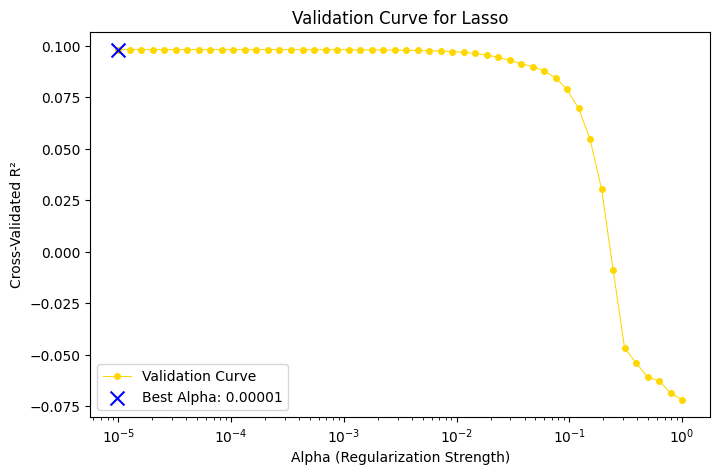


Best alpha: 0.00001


In [337]:
# Range of alpha values
alpha_range = np.logspace(-5, 0, 50)
scores = []

# Compute cross-validated R2 for each alpha
for alpha in alpha_range:
    lasso = Lasso(alpha=alpha, random_state=12)
    cv_scores = cross_val_score(lasso, df_reg_x_train, df_reg_y_train.squeeze(), cv=5, scoring='r2')
    scores.append(np.mean(cv_scores))

# Best alpha
best_alpha_lasso = alpha_range[np.argmax(scores)]
best_score = max(scores)

# Plot the validation curve
plt.figure(figsize=(8, 5))
plt.plot(alpha_range, scores, color='gold', marker='o', linewidth=0.75, markersize=4, label="Validation Curve")
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Cross-Validated R²")
plt.title("Validation Curve for Lasso")

# Highlight the best alpha
plt.scatter([best_alpha_lasso], [best_score], color='blue', marker='x', s=100, zorder=5, label=f"Best Alpha: {best_alpha_lasso:.5f}")

# Add legend
plt.legend()
plt.show()

# Print Best alpha
print(f"\nBest alpha: {best_alpha_lasso:.5f}")

In [338]:
# Lasso: Initialize and Train
lasso_model = Lasso(alpha=best_alpha_lasso, random_state=12)
lasso_model.fit(df_reg_x_train, df_reg_y_train.squeeze())

# Print coefficients
formatted_coefficients = np.array2string(lasso_model.coef_, formatter={'all': lambda x: f'{x:.2f}'})

print("Lasso Model Coefficients:")
print(f"{formatted_coefficients}\n")

# Predict on the test set
y_pred_lasso = lasso_model.predict(df_reg_x_test)

# Get Metrics
y_test_series = df_reg_y_test.squeeze() # DataFrame to Series

r2_lasso = r2_score(y_test_series, y_pred_lasso)
mse_lasso = mean_squared_error(y_test_series, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test_series, y_pred_lasso)
medae_lasso = median_absolute_error(y_test_series, y_pred_lasso)

print("Metrics:")
print(f"  R-squared: {r2_lasso}")
print(f"  Mean Squared Error: {mse_lasso}")
print(f"  Mean Absolute Error: {mae_lasso}")
print(f"  Median Absolute Error: {medae_lasso}\n")

Lasso Model Coefficients:
[-0.07 0.17 0.14 -1.17]

Metrics:
  R-squared: -0.28439908332516106
  Mean Squared Error: 2.580370809513424
  Mean Absolute Error: 1.4091831598720308
  Median Absolute Error: 1.2521940393047344



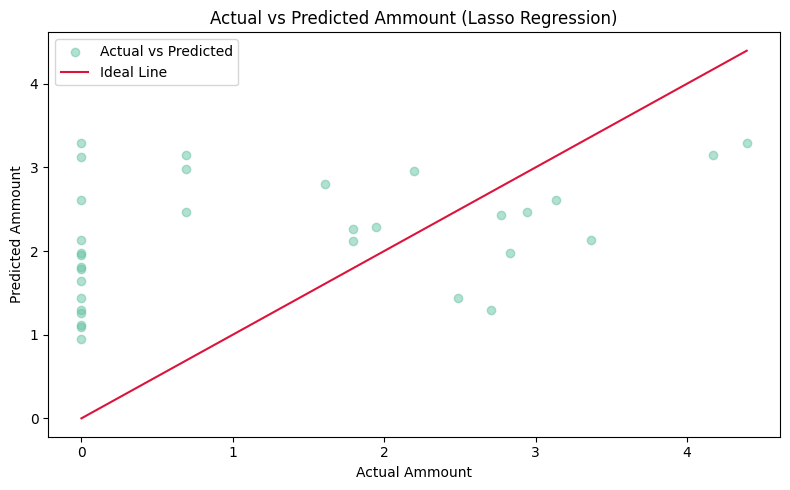

In [339]:
plt.figure(figsize=(8, 5))

# Plot: Lasso
plt.scatter(y_test_series, y_pred_lasso, color=colors[0], alpha=0.5, label='Actual vs Predicted')
plt.plot(
    [min(y_test_series.min(), y_pred_lasso.min()), max(y_test_series.max(), y_pred_lasso.max())],
    [min(y_test_series.min(), y_pred_lasso.min()), max(y_test_series.max(), y_pred_lasso.max())],
    color='crimson', linestyle='-', label='Ideal Line'
)
plt.xlabel("Actual Ammount")
plt.ylabel("Predicted Ammount")
plt.title("Actual vs Predicted Ammount (Lasso Regression)")
plt.legend()

plt.tight_layout()
plt.show()

### _Ridge Regression_

Unlike Lasso, Ridge **only penalizes the coefficients instead of completely eliminating them**. I decided to try this model to see if the poor performance of Lasso was due to that difference, but **the results were equally unsatisfactory**.

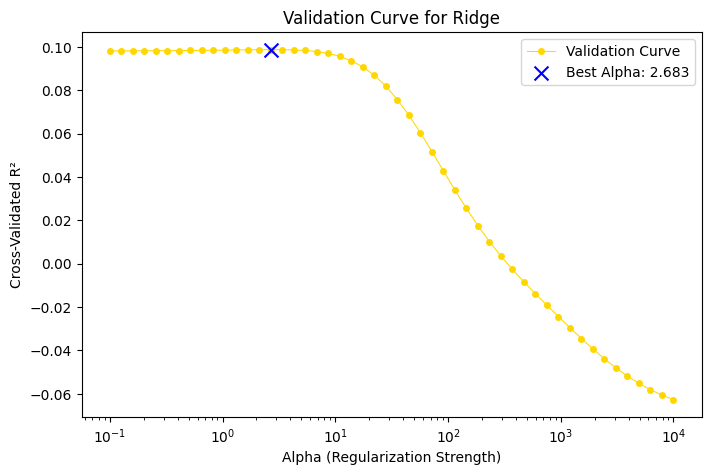


Best alpha: 2.683


In [340]:
# Range of alpha values
alpha_range = np.logspace(-1, 4, 50)
scores = []

# Compute cross-validated R2 for each alpha
for alpha in alpha_range:
    ridge = Ridge(alpha=alpha, random_state=12)
    cv_scores = cross_val_score(ridge, df_reg_x_train, df_reg_y_train.squeeze(), cv=5, scoring='r2')
    scores.append(np.mean(cv_scores))

# Best alpha
best_alpha_ridge = alpha_range[np.argmax(scores)]
best_score = max(scores)

# Plot the validation curve
plt.figure(figsize=(8, 5))
plt.plot(alpha_range, scores, color='gold', marker='o', linewidth=0.75, markersize=4, label="Validation Curve")
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Cross-Validated R²")
plt.title("Validation Curve for Ridge")

# Highlight the best alpha
plt.scatter([best_alpha_ridge], [best_score], color='blue', marker='x', s=100, zorder=5, label=f"Best Alpha: {best_alpha_ridge:.3f}")

# Add legend
plt.legend()
plt.show()

# Print Best alpha
print(f"\nBest alpha: {best_alpha_ridge:.3f}")

In [341]:
# Ridge: Initialize and Train
ridge_model = Ridge(alpha=best_alpha_ridge, random_state=12)
ridge_model.fit(df_reg_x_train, df_reg_y_train.squeeze())

# Print coefficients
formatted_coefficients = np.array2string(ridge_model.coef_, formatter={'all': lambda x: f'{x:.2f}'})

print("Ridge Model Coefficients:")
print(f"{formatted_coefficients}\n")

# Predict on the test set
y_pred_ridge = ridge_model.predict(df_reg_x_test)

# Get Metrics
y_test_series = df_reg_y_test.squeeze() # DataFrame to Series

r2_ridge = r2_score(y_test_series, y_pred_ridge)
mse_ridge = mean_squared_error(y_test_series, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test_series, y_pred_ridge)
medae_ridge = median_absolute_error(y_test_series, y_pred_ridge)

print("Metrics:")
print(f"  R-squared: {r2_ridge}")
print(f"  Mean Squared Error: {mse_ridge}")
print(f"  Mean Absolute Error: {mae_ridge}")
print(f"  Median Absolute Error: {medae_ridge}\n")

Ridge Model Coefficients:
[-0.07 0.17 0.14 -1.11]

Metrics:
  R-squared: -0.28244892992550086
  Mean Squared Error: 2.576452931517491
  Mean Absolute Error: 1.4109927477730442
  Median Absolute Error: 1.2533433156440978



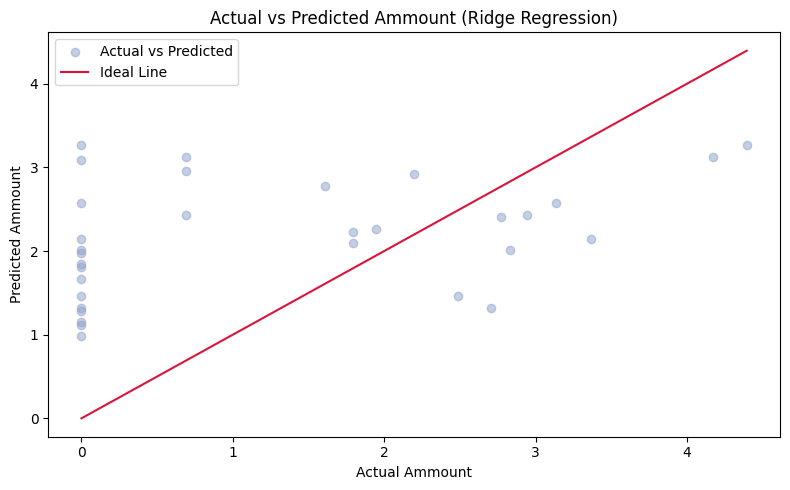

In [342]:
plt.figure(figsize=(8, 5))

# Plot: Ridge
plt.scatter(y_test_series, y_pred_ridge, color=colors[2], alpha=0.5, label='Actual vs Predicted')
plt.plot(
    [min(y_test_series.min(), y_pred_ridge.min()), max(y_test_series.max(), y_pred_ridge.max())],
    [min(y_test_series.min(), y_pred_ridge.min()), max(y_test_series.max(), y_pred_ridge.max())],
    color='crimson', linestyle='-', label='Ideal Line'
)
plt.xlabel("Actual Ammount")
plt.ylabel("Predicted Ammount")
plt.title("Actual vs Predicted Ammount (Ridge Regression)")
plt.legend()

plt.tight_layout()
plt.show()

## 6.3 - Other Regressors

It seems that the relationship is not linear. For this reason, we will explore other methods that are better suited to capture non-linear, more complex relationships.

### _Random Forest Regressor_

**Random Forest Regressor** uses a set of **Decision Trees** to operate. Here, each tree makes a decision, and then all the individual decisions are averaged to give a final prediction. The main strength of this model is its ability to handle non-linear relationships with ease.

We also performed hyperparameter tuning with validation curves for this method, but in the end, the results, while slightly better, **were still not very good**.

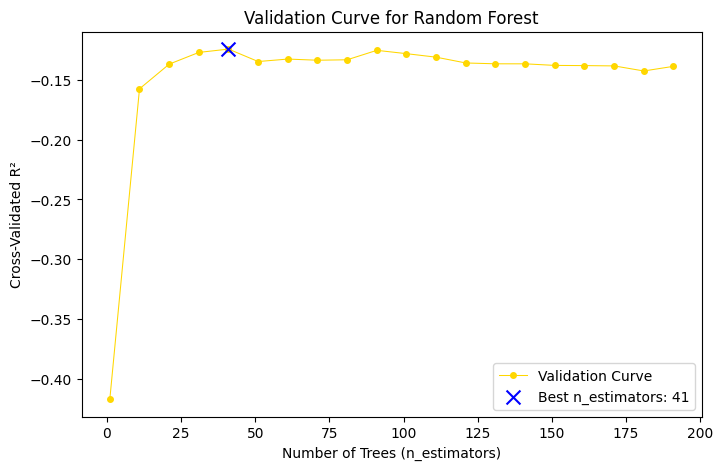


Best n_estimators: 41


In [343]:
# Range of n_estimators values
n_estimators_range = range(1, 201, 10)  # Values from 10 to 200 with a step of 10
scores = []

# Compute cross-validated R2 for each n_estimators
for n_estimators in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=12, max_depth=None)
    cv_scores = cross_val_score(rf, df_reg_x_train, df_reg_y_train.squeeze(), cv=5, scoring='r2')
    scores.append(np.mean(cv_scores))

# Best n_estimators
best_n_estimators = n_estimators_range[np.argmax(scores)]
best_score = max(scores)

# Plot the validation curve
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, scores, color='gold', marker='o', linewidth=0.75, markersize=4, label="Validation Curve")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Cross-Validated R²")
plt.title("Validation Curve for Random Forest")

# Highlight the best n_estimators
plt.scatter([best_n_estimators], [best_score], color='blue', marker='x', s=100, zorder=5, label=f"Best n_estimators: {best_n_estimators}")

# Add legend
plt.legend()
plt.show()

# Print Best n_estimators
print(f"\nBest n_estimators: {best_n_estimators}")

In [344]:
# Random Forest: Initialize and Train
rf_model = RandomForestRegressor(
    n_estimators=best_n_estimators,
    random_state=12,
    max_depth=None
)
rf_model.fit(df_reg_x_train, df_reg_y_train.squeeze())

# Print feature importances
formatted_importances = np.array2string(
    rf_model.feature_importances_, formatter={'all': lambda x: f'{x:.2f}'}
)

print("Random Forest Feature Importances:")
print(f"{formatted_importances}\n")

# Predict on the test set
y_pred_rf = rf_model.predict(df_reg_x_test)

# Get Metrics
y_test_series = df_reg_y_test.squeeze()  # DataFrame to Series

r2_rf = r2_score(y_test_series, y_pred_rf)
mse_rf = mean_squared_error(y_test_series, y_pred_rf)
mae_rf = mean_absolute_error(y_test_series, y_pred_rf)
medae_rf = median_absolute_error(y_test_series, y_pred_rf)

print("Metrics:")
print(f"  R-squared: {r2_rf}")
print(f"  Mean Squared Error: {mse_rf}")
print(f"  Mean Absolute Error: {mae_rf}")
print(f"  Median Absolute Error: {medae_rf}\n")

Random Forest Feature Importances:
[0.28 0.45 0.06 0.20]

Metrics:
  R-squared: -0.4488007675428516
  Mean Squared Error: 2.910655463635041
  Mean Absolute Error: 1.0466470072503582
  Median Absolute Error: 0.33478734588054604



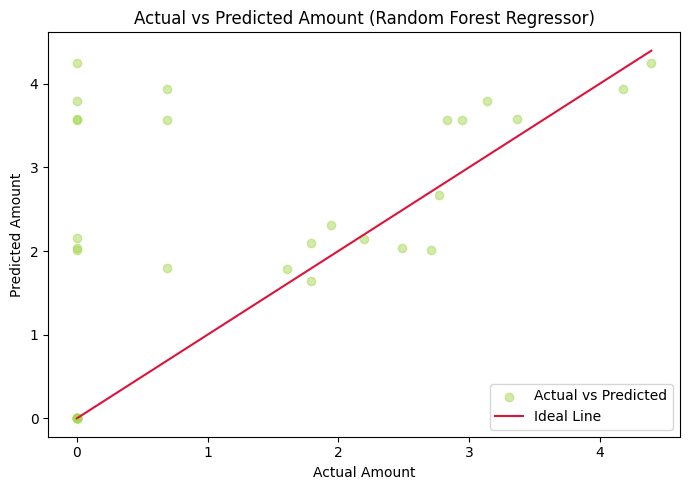

In [345]:
plt.figure(figsize=(7, 5))

# Plot: Random Forest Regressor
plt.scatter(df_reg_y_test.squeeze(), y_pred_rf, color=colors[4], alpha=0.5, label='Actual vs Predicted')
plt.plot(
    [min(df_reg_y_test.squeeze().min(), y_pred_rf.min()), max(df_reg_y_test.squeeze().max(), y_pred_rf.max())],
    [min(df_reg_y_test.squeeze().min(), y_pred_rf.min()), max(df_reg_y_test.squeeze().max(), y_pred_rf.max())],
    color='crimson', linestyle='-', label='Ideal Line'
)
plt.xlabel("Actual Amount")
plt.ylabel("Predicted Amount")
plt.title("Actual vs Predicted Amount (Random Forest Regressor)")
plt.legend()

plt.tight_layout()
plt.show()

Although the results were not entirely satisfactory, we started to see some improvements in the graph. The model correctly predicts some *zeros* and values greater than $1.5$.

### _Support Vector Regressor_

Another alternative based on *SVMs*. **SVR** is particularly useful when the data has a **clear separation**, although it requires intensive preprocessing. In this case, our data has some discretization, so we can consider them separated when making predictions; and as for preprocessing, everything has been done correctly as well.

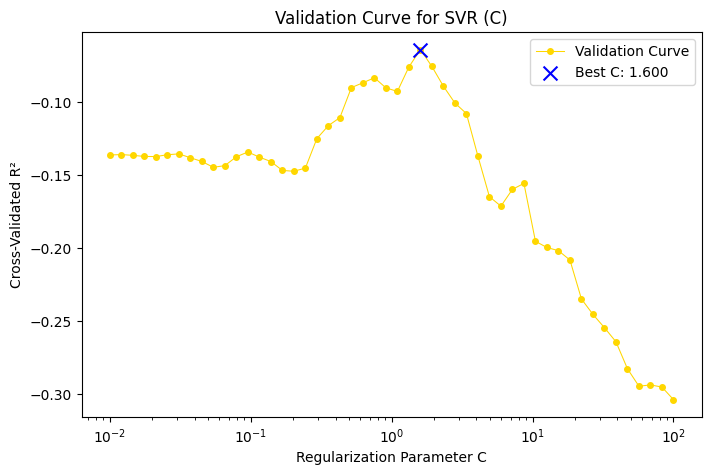


Best C: 1.600


In [346]:
# Range of C values
C_range = np.logspace(-2, 2, 50)  # Values from 0.001 to 1000
scores = []

# Compute cross-validated R2 for each C
for C in C_range:
    svr = SVR(C=C, epsilon=0.1)
    cv_scores = cross_val_score(svr, df_reg_x_train, df_reg_y_train.squeeze(), cv=5, scoring='r2')
    scores.append(np.mean(cv_scores))

# Best C
best_C = C_range[np.argmax(scores)]
best_score = max(scores)

# Plot the validation curve
plt.figure(figsize=(8, 5))
plt.plot(C_range, scores, color='gold', marker='o', linewidth=0.75, markersize=4, label="Validation Curve")
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel("Regularization Parameter C")
plt.ylabel("Cross-Validated R²")
plt.title("Validation Curve for SVR (C)")

# Highlight the best C
plt.scatter([best_C], [best_score], color='blue', marker='x', s=100, zorder=5, label=f"Best C: {best_C:.3f}")

# Add legend
plt.legend()
plt.show()

# Print Best C
print(f"\nBest C: {best_C:.3f}")

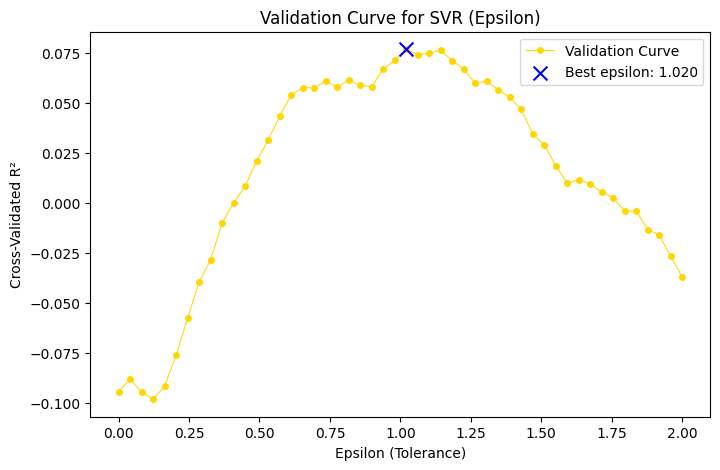


Best epsilon: 1.020


In [347]:
# Range of epsilon values
epsilon_range = np.linspace(0, 2, 50)
scores = []

# Compute cross-validated R2 for each epsilon
for epsilon in epsilon_range:
    svr = SVR(C=1.0, epsilon=epsilon)
    cv_scores = cross_val_score(svr, df_reg_x_train, df_reg_y_train.squeeze(), cv=5, scoring='r2')
    scores.append(np.mean(cv_scores))

# Best epsilon
best_epsilon = epsilon_range[np.argmax(scores)]
best_score = max(scores)

# Plot the validation curve
plt.figure(figsize=(8, 5))
plt.plot(epsilon_range, scores, color='gold', marker='o', linewidth=0.75, markersize=4, label="Validation Curve")
plt.xlabel("Epsilon (Tolerance)")
plt.ylabel("Cross-Validated R²")
plt.title("Validation Curve for SVR (Epsilon)")

# Highlight the best epsilon
plt.scatter([best_epsilon], [best_score], color='blue', marker='x', s=100, zorder=5, label=f"Best epsilon: {best_epsilon:.3f}")

# Add legend
plt.legend()
plt.show()

# Print Best epsilon
print(f"\nBest epsilon: {best_epsilon:.3f}")

In [348]:
# SVR: Initialize and Train
svr_model = SVR(C=best_C, epsilon=best_epsilon)
svr_model.fit(df_reg_x_train, df_reg_y_train.squeeze())

# Predict on the test set
y_pred_svr = svr_model.predict(df_reg_x_test)

# Get Metrics
y_test_series = df_reg_y_test.squeeze()  # DataFrame to Series

r2_svr = r2_score(y_test_series, y_pred_svr)
mse_svr = mean_squared_error(y_test_series, y_pred_svr)
mae_svr = mean_absolute_error(y_test_series, y_pred_svr)
medae_svr = median_absolute_error(y_test_series, y_pred_svr)

print("SVR Metrics:")
print(f"  R-squared: {r2_svr}")
print(f"  Mean Squared Error: {mse_svr}")
print(f"  Mean Absolute Error: {mae_svr}")
print(f"  Median Absolute Error: {medae_svr}\n")

SVR Metrics:
  R-squared: -0.2638234881708177
  Mean Squared Error: 2.5390342297743738
  Mean Absolute Error: 1.3526058016663498
  Median Absolute Error: 1.2273103929848497



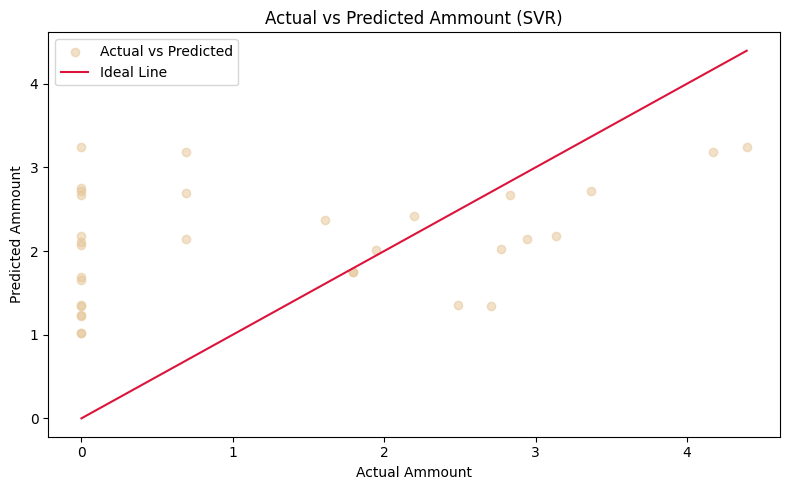

In [349]:
plt.figure(figsize=(8, 5))

# Plot: SVR
plt.scatter(y_test_series, y_pred_svr, color=colors[6], alpha=0.5, label='Actual vs Predicted')
plt.plot(
    [min(y_test_series.min(), y_pred_svr.min()), max(y_test_series.max(), y_pred_svr.max())],
    [min(y_test_series.min(), y_pred_svr.min()), max(y_test_series.max(), y_pred_svr.max())],
    color='crimson', linestyle='-', label='Ideal Line'
)
plt.xlabel("Actual Ammount")
plt.ylabel("Predicted Ammount")
plt.title("Actual vs Predicted Ammount (SVR)")

# Add legend
plt.legend()
plt.tight_layout()
plt.show()

These were the best results obtained. Although they are better than some of the previous models, it seems that **this model will also not provide an adequate solution to the problem**, as just looking at the negative $R^2$ value is enough to understand the level of performance.

# **7 - Conclusions and Final Thoughts**

After exploring the multiple approaches and algorithms for this dataset, there are some important considerations and insights that emerged from this experimentation and are open for discussion.

Initially, the process of **data preparation** and **descriptive statistics** went smoothly. It was possible to visualize the dataset holistically and extract some general insights.

However, while the preliminary and initial analysis of the data through various **EDA** techniques seemed to suggest promising results, some of the initial questions remain unresolved. Take, for example, the case of transplant patient groups (clustering) or donation prediction (regression). Despite exploring several different approaches and carefully analyzing their methods, strengths, and differences, the data doesn’t seem to provide meaningful insights after applying the models.

That being said, this is not a definitive outcome. There is undoubtedly room to continue exploring other alternatives to tackle the problem. Whether through **different clustering models** or the use of **time series algorithms**, data science offers us countless possibilities to approach these challenges and attempt to answer these questions.

Additionally, from a social perspective, the impact of this type of analysis in a formal setting can potentially create positive change for the communities involved. Whether it's making life easier for a patient, optimizing transplant waiting list systems, or similar initiatives, the impact of data mining is profound in its area of application. It is worth dedicating efforts to these kinds of initiatives.